# Домашнее задание 4: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающего дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

<font color=blue>

Если $p_1$ и $p_2$ частоты распределения классов $k_1$ и $k_2$ соответственно, то энтропия такого распределения будет $entropy = -(p_1\cdot\ln p_1 + p_2\cdot\ln p_2)$.
    
</font>

In [2]:
p1 = 8/10
p2 = 2/10
print(f'entropy: {-(p1 * np.log(p1) + p2 * np.log(p2)):.2f}')

entropy: 0.50


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

<font color=blue>

В случае разбиения, когда влево идут элементы только класса $k_1$,  а вправо - только класса $k_2$, получаем, что $H(R_l)=H(R_r)=0$. Поэтому максимум $Q(R_m, j, t) = H(R_m) = p_1(1-p_1) + p_2(1-p_2)=1-(p_1^2 + p_2^2)$.

</font>

In [3]:
print(f'Q = {1-p1**2-p2**2:.2f}')

Q = 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

<font color=blue>

Для задачи регрессии берется среднее значение целевых значений элементов, которые попали в листовую вершину дерева.    
    
</font>

In [4]:
leaf_targets =  [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
print(f'prediction: {np.mean(leaf_targets)}')

prediction: 40.6


<font color=blue>
Для дальнейших задач отключим предупреждения.
</font>

In [5]:
import warnings
warnings.filterwarnings('ignore')

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [6]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

<font color=blue>
    
Пояснения к реализации функции `find_best_split`.

Внутренняя функция `def impurity(targets)` вычисляет и возвращает меру "хаотичности" входного массива `targets` (несмещенную дисперсию для регрессии, либо индекс Джинни для классификации), умноженную на длину этого массива. Умножение делается для удобства последующей нормировки, когда нужно будет вычислять критерий информативности разбиения корневой вершины.
    
Внутренняя функция `def left_condition(threshold, vector)` возвращает для порога разбиения `threshold` маску для элементов массива `vector`, которые после разбиения попадают в левое поддерево.

Внутренняя функция `def calc_impurities(threshold)` вычисляет и возвращает критерий информативности разбиения корневой вершины для заданного порога разбиения `threshold`.

Дальнейшие пояснения см. в тексте функции `find_best_split`
</font>

In [7]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
    def impurity(targets):
        size = len(targets)
        if task == 'regression':
            return np.var(targets, ddof=1) * size if size > 1 else 0
        elif task == 'classification':
            freqs = Counter(targets)
            probs = np.array([freqs[cls]/size for cls in freqs])
            return size - size * np.sum(probs ** 2)
        else:
            raise ValueError(f'There is unknown task type: {task}')
    
    def left_condition(threshold, vector):
        if feature_type == 'real':
            return vector < threshold
        elif feature_type == 'categorical':
            return vector == threshold
        else: 
            ValueError(f'There is unknown feature type: {feature_type}')
    
    def calc_impurities(threshold):
        condition = left_condition(threshold, feature_vector)
        impurity_left = impurity(target_vector[condition])
        impurity_right = impurity(target_vector[~condition])
        return (impurity_root - impurity_left - impurity_right) / len(target_vector)
        
    # вычислим массив возможных порогов разбиения thresholds
    if feature_type == 'real':
        sorted_feature_vector = np.unique(np.sort(feature_vector))
        thresholds = (sorted_feature_vector[:-1] + sorted_feature_vector[1:]) / 2.0
    elif feature_type == 'categorical':
        thresholds = np.unique(feature_vector)
    else:
        raise ValueError(f'There is unknown feature type: {feature_type}')
    
    # вычислим меру хаотичности корневой вершины, умноженную на размер корневой вершины
    impurity_root = impurity(target_vector)
    
    # векторизованным способом вычислим для каждого порога разбиения из массива thresholds 
    # критерий информативности разбиения, получим массив impurities значений критерия
    impurities = np.vectorize(calc_impurities)(thresholds)
    
    # найдем максимум критерия информативности
    impurity_best = np.max(impurities)
    
    # найдем порог, соответствующий максимуму критерия информативности
    threshold_best = thresholds[np.argmax(impurities)]
                 
    return  thresholds, impurities, threshold_best, impurity_best


Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

<font color=blue>

Из новых версий `sklearn` этот датасет изъят, поэтому скачаем его из `https://lib.stat.cmu.edu/datasets/boston`.
</font>

In [8]:
data_url = "https://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :3]])
columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df_data = pd.DataFrame(data, columns = columns)
X = df_data.drop(columns='MEDV')
y = df_data[['MEDV']]

In [9]:
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

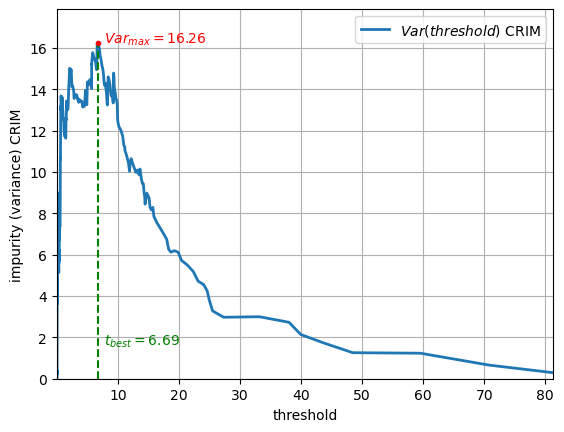

In [10]:
ax = plt.subplot()
_ = ax.plot(thresholds, variances, linewidth=2.0, label='$Var(threshold)$ CRIM')
_ = ax.plot(threshold_best, variance_best, 'ro', markersize=3)
ax.axvline(threshold_best, ymax = 0.9, linestyle = '--', color='green')
ax.text(threshold_best + 1,
        variance_best * 0.1, 
        f'$t_{{best}}=${threshold_best:.2f}',
        color='green',
        fontsize=10)
ax.text(threshold_best + 1,
        variance_best, 
        f'$Var_{{max}}=${variance_best:.2f}',
        color='red',
        fontsize=10)
ax.grid(True)
ax.set_ylabel('impurity (variance) CRIM')
ax.set_xlabel('threshold')
_ = ax.set(xlim=(min(thresholds), max(thresholds)), ylim=(0, variance_best * 11/10))
_ = ax.legend()

<font color=blue>
    
Протестируем также работу функции `find_best_split` на категориальном признаке.

</font>

In [11]:
feature_vector = np.array([ 'b', 'a', 'c', 'c', 'c', 'b', 'd', 'd', 'e'])
target_vector = np.array([ 1, 0, 0, 0, 1, 10,  10, 20, 1])

thresholds, impurities, threshold_best, impurity_best = find_best_split(
    feature_vector, 
    target_vector, 
    task="regression",
    feature_type="categorical"
)

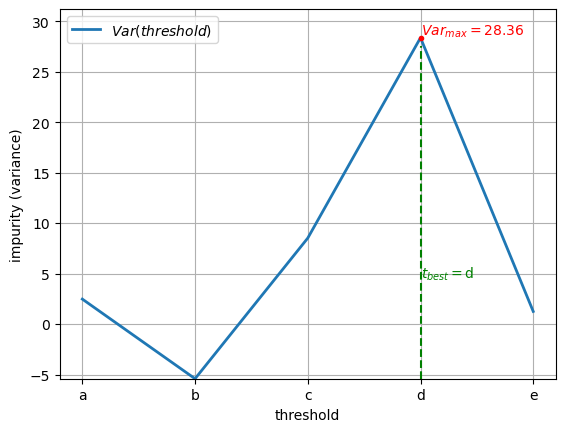

In [12]:
ax = plt.subplot()
_ = ax.plot(thresholds, impurities, linewidth=2.0, label='$Var(threshold)$')
_ = ax.plot(threshold_best, impurity_best, 'ro', markersize=3)
ax.axvline(threshold_best, ymax = 0.9, linestyle = '--', color='green')
ax.text(np.where(thresholds == threshold_best)[0], 
       (impurity_best + min(impurities)) * 0.2, 
        f'$t_{{best}}=${threshold_best}', 
        color="green", 
        fontsize=10)
ax.text(np.where(thresholds == threshold_best)[0],
        impurity_best + 0.3, 
        f'$Var_{{max}}=${impurity_best:.2f}',
        color='red',
        fontsize=10)
ax.grid(True)
ax.set_ylabel('impurity (variance)')
ax.set_xlabel('threshold')
_ = ax.set(ylim=(min(impurities), impurity_best*11/10))
_ = ax.legend()

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [13]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    # вычисляем маску также как это делалось в функции find_best_split
                    split = feature_vector < threshold # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    # вычисляем маску также как это делалось в функции find_best_split
                    split = feature_vector == threshold # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
        # обходим дереево
        current_node = node
        # пока не дошли до листьевого узла
        while current_node['type'] != 'terminal':
            # получаем индекс лучшего признака
            feature_best = current_node["feature_split"]
            
            # если признак действительный, то:
            if self._feature_types[feature_best] == "real":
                # получаем лучший порог разбиения
                threshold_best = curent_node["threshold"]
                
                # если значение лучшего признака меньше порога, то переходим в левое поддерево иначе в правое
                if x[feature_best] < threshold_best:
                    current_node = current_node['left_child']
                else:
                    current_node = current_node['right_child']
        
            # аналогичная логика перехода в левое/правое поддерево для категориального признака
            elif self._feature_types[feature_best] == "categorical":
                threshold_best = current_node["category_split"]
                
                if x[feature_best] == threshold_best:
                    current_node = current_node['left_child']
                else:
                    current_node = current_node['right_child']
            else:
                raise ValueError         
        
        # когда дошли до листьевого узла возвращаем предсказанный класс
        return current_node['class']

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [14]:
df_students = pd.read_csv('students.csv')
df_students = df_students.drop(columns=['Unnamed: 0'])
df_students.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


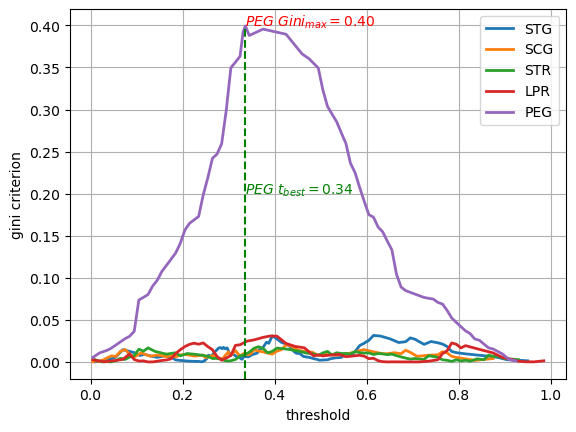

In [15]:
target_vector = df_students['UNS']
ax = plt.subplot()
for column in df_students.columns[:-1]:
    feature_vector = df_students[column].to_numpy()
    thresholds, ginis, threshold_best, gini_best = find_best_split(feature_vector, 
                                                                   target_vector, 
                                                                   task="classification", 
                                                                   feature_type="real")
    _ = ax.plot(thresholds, ginis, linewidth=2.0, label=column)
    if column == 'PEG':
        ax.axvline(threshold_best, ymax = 0.95, linestyle = '--', color='green')
        ax.text(threshold_best,  (gini_best+min(ginis))/2, 
                f'$PEG\,\,t_{{best}}=${threshold_best:.2f}', 
                color='green')
        ax.text(threshold_best,  gini_best, 
                f'$PEG\,\,Gini_{{max}}=${gini_best:.2f}', 
                color='red')
        
    
ax.grid(True)
ax.set_ylabel('gini criterion')
ax.set_xlabel('threshold')
_ = ax.legend()
plt.show()

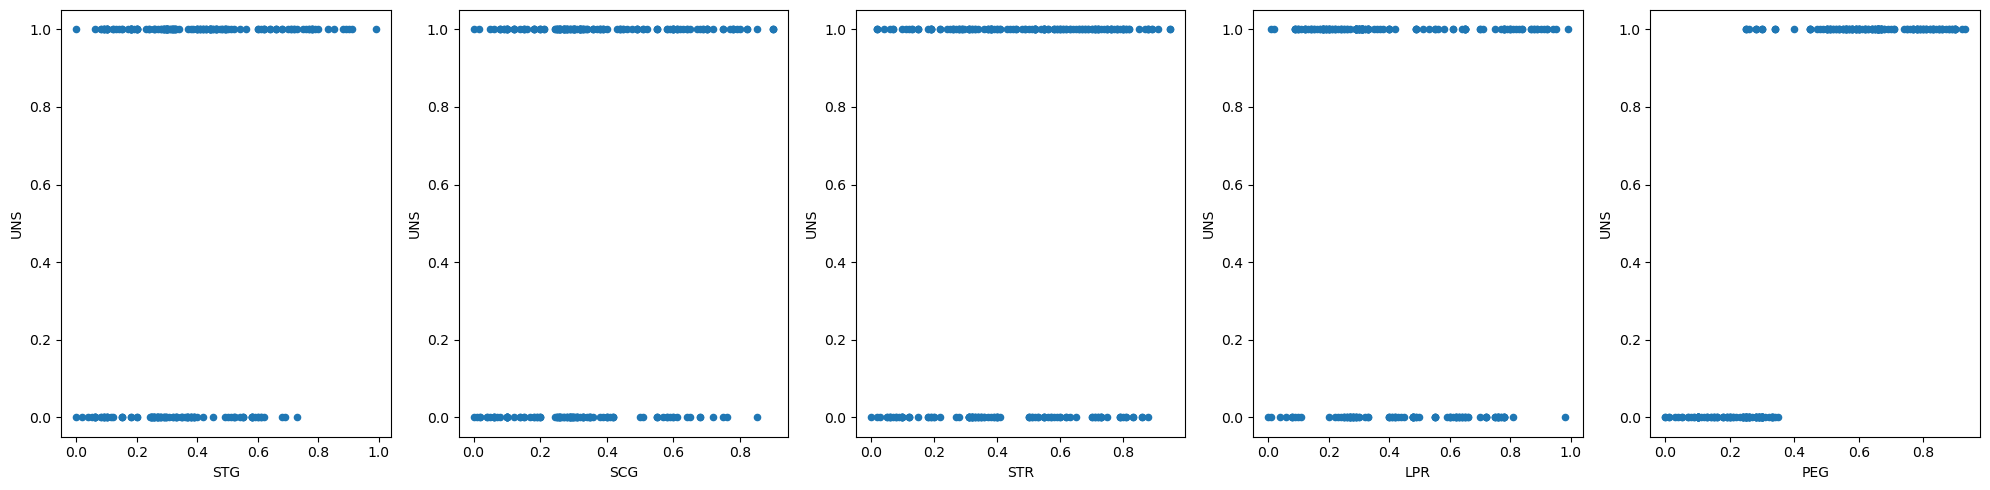

In [16]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, column in enumerate(df_students.columns[:-1]):
    df_students.plot.scatter(column, 'UNS', ax = axs[i])
plt.tight_layout()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

<font color=blue>

Максимум значения критерия Джини ($\approx 0.4$) достигается для признака `PEG` (значение порога $\approx 0.34$). Это согласуется с диаграммой рассеяния `PEG - UNS`. На этой диаграмме вертикальная линия с пороговым значением `PEG = 0.34` довольно точно разделяет выборку на 2 класса (слева класс 0, справа класс 1). Наличие такой вертикальной границы на диаграмме рассеяния "признак - класс" говорит о том, что признак "хороший" (по нему выборка делится почти идеально). Признаки, по которым такое разделение почти невозможно имеют кривые, очень близко прилегающие к оси абсцисс, т.е. максимальное значение критерия Джини близко к 0 (в нашем случае этот максимум для всех "плохих" признаков не превышает 0.05).

</font>

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [18]:
df_mush = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data')
df_mush.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


In [19]:
df_mush_encoded = df_mush.apply(LabelEncoder().fit_transform)
df_mush_encoded.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1


In [20]:
X = np.asarray(df_mush_encoded.drop(columns=['p']))
y = np.asarray(df_mush_encoded['p'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [21]:
dt = DecisionTree(feature_types = ['categorical'] * X.shape[1])
dt.fit(X_train, y_train)
pred_test = dt.predict(X_test)
print(f'accuracy: {accuracy_score(y_test, pred_test)}')

accuracy: 1.0


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [22]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [23]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

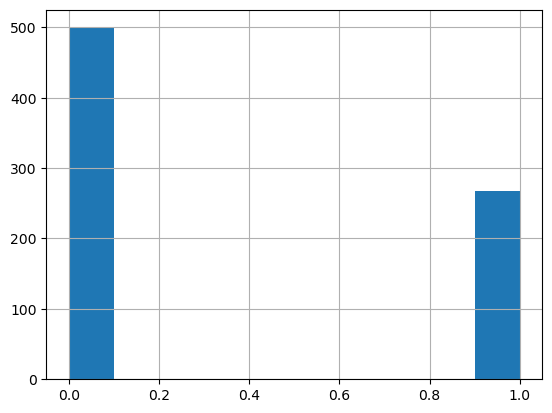

In [24]:
data['Outcome'].hist()
plt.show()

<font color=blue>

Проверим есть ли в данных `null` значения.    

</font>

In [25]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

<font color=blue>

Таких значений нет.    
 
</font>

In [26]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<font color=blue>
    
Судя по выводу `describe` многие признаки имеют минимальные значения 0, заменим их на средние по выборке.  
   
</font>

In [27]:
data['BMI'] = data['BMI'].replace(0, data['BMI'].mean())
data['BloodPressure'] = data['BloodPressure'].replace(0, data['BloodPressure'].mean())
data['Glucose'] = data['Glucose'].replace(0, data['Glucose'].mean())
data['Insulin'] = data['Insulin'].replace(0, data['Insulin'].mean())
data['SkinThickness'] = data['SkinThickness'].replace(0, data['SkinThickness'].mean())

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [28]:
X = data.drop(columns=['Outcome'])
y = data.Outcome
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

<font color=blue>

Переберем в двойном цикле все модели. Результаты будем записывать в словарь `results`.
</font>

In [29]:
max_depth_list = np.linspace(1, 10, 10, dtype='int16')
min_samples_leaf_list = np.linspace(1, 10, 10, dtype='int16')
results = { 'max_depth': list(),
            'min_samples_leaf': list(),
            'val_f1_score': list()}

for max_depth in max_depth_list:
    for min_samples_leaf in min_samples_leaf_list:
        results['max_depth'].append(max_depth)
        results['min_samples_leaf'].append(min_samples_leaf)
        dtc = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        results['val_f1_score'].append(f1_score(y_valid, dtc.fit(X_train, y_train).predict(X_valid)))
        
        

<font color=blue>
    
Построим фрейм с результами отсортированными по `f1_score`.

</font>

In [30]:
df_res = pd.DataFrame(results).sort_values(by=['val_f1_score'], ascending=False).reset_index(drop=True)
df_res.head()

,max_depth,min_samples_leaf,val_f1_score
0,5,10,0.590164
1,5,9,0.590164
2,5,8,0.584615
3,6,1,0.583333
4,5,7,0.582677


<font color=blue>

Запомним лучшие гиперпараметры (на которых был получен максимальный `f1_score` во время валидации).

</font>

In [31]:
best_max_depth = df_res.max_depth[0]
best_min_samples_leaf = df_res.min_samples_leaf[0]

<font color=blue>

Создадим полную обучающую выборку.    
    
</font>

In [32]:
X_train_full = pd.concat([X_train, X_valid], ignore_index=True)
y_train_full = pd.concat([y_train, y_valid], ignore_index=True)

<font color=blue>
 
Создадим список `experiments` с результатами экспериментов.

</font>

In [33]:
experiments = list()

In [34]:
# функция расчета метрик
def calc_metrics(y_true, y_pred, y_score, experiment_name, verbose=True):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_score)
    f1 = f1_score(y_true, y_pred)
    
    if verbose:
        print(f'accuracy: {accuracy:.2f}')
        print(f'recall: {recall:.2f}')
        print(f'precision: {precision:.2f}')
        print(f'roc auc: {roc_auc:.2f}')
        print(f'f1: {f1:.2f}')
        
    return  experiment_name, accuracy, recall, precision, roc_auc, f1 

<font color=blue>
    
Обучим решающее дерево с подобранными гиперпараметрами на полной обучающей выборке. Оценим качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`, `f1`.

</font>

In [35]:
dtc = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, random_state=42)
dtc.fit(X_train_full, y_train_full)
experiments.append(calc_metrics(y_test, dtc.predict(X_test), dtc.predict_proba(X_test)[:,1], 'Decision Tree Classifier'))

accuracy: 0.78
recall: 0.56
precision: 0.76
roc auc: 0.83
f1: 0.64


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

<font color=blue>

Сначала обучим `BaggingClassifier` с параметром `estimator` по умолчанию.    
    
</font>

In [36]:
bc = BaggingClassifier(n_estimators=50, random_state=42)
bc.fit(X_train_full, y_train_full)
experiments.append(calc_metrics(y_test, bc.predict(X_test), bc.predict_proba(X_test)[:,1], 'Bagging Classifier (default)'))

accuracy: 0.74
recall: 0.57
precision: 0.65
roc auc: 0.82
f1: 0.61


<font color=blue>

Теперь передадим в конструктор  `BaggingClassifier` в качестве базового классификатора предыдущий классификатор `dtc` (`DecisionTreeClassifier` с лучшими гиперпараметрами).

</font>

In [37]:
bc = BaggingClassifier(estimator=dtc, n_estimators=50, random_state=42)
bc.fit(X_train_full, y_train_full)
experiments.append(calc_metrics(y_test, bc.predict(X_test), bc.predict_proba(X_test)[:,1], 'Bagging Classifier (best dtc)'))

accuracy: 0.75
recall: 0.56
precision: 0.68
roc auc: 0.84
f1: 0.61


<font color=blue>

Качество немного улучшилось.

</font>

**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [39]:
# будем искать max_depth от 1 до 10 и min_samples_split от 2 до 10
rf_params = { 'max_depth': np.linspace(1, 10, 10, dtype='int16'),
              'min_samples_split': np.linspace(2, 10, 9, dtype='int16')}


rf = RandomForestClassifier(n_estimators=50, random_state=42)

# используем StratifiedKFold для получения одинакового баланса
# классов на трейне и тесте для каждого из 5 фолдов
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# cоздадим кросс-валидационный грид для перебора (скоринг отбора лучших параметров - f1)
rf_cv = GridSearchCV(rf, rf_params, scoring='f1', cv=skf, verbose=1)

# запустим перебор по решетке с кросс-валидацией
_  = rf_cv.fit(X_train_full, y_train_full)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


<font color=blue>
   
Посмотрим на лучшие найденные параметры и лучшее среднее значение f1
    
</font>

In [40]:
print(f'best f1: {rf_cv.best_score_:.2f}')
print(f'best params: {rf_cv.best_params_}')

best f1: 0.66
best params: {'max_depth': 10, 'min_samples_split': 4}


<font color=blue>
Обучим случайный лес с подобранными гиперпараметрами на полной обучающей выборке. Оценим качество классификации по тем же метрикам.
</font>

In [41]:
best_max_depth = rf_cv.best_params_['max_depth']
best_min_samples_split = rf_cv.best_params_['min_samples_split']

rf = RandomForestClassifier(n_estimators=50,
                            random_state=42,
                            max_depth=best_max_depth,
                            min_samples_split=best_min_samples_split)
rf.fit(X_train_full, y_train_full)
experiments.append(calc_metrics(y_test, rf.predict(X_test), rf.predict_proba(X_test)[:,1], 'Random Forest Classifier'))

accuracy: 0.74
recall: 0.57
precision: 0.66
roc auc: 0.83
f1: 0.61


<font color=blue>

Посмотрим на результаты экспериментов.
 
</font>

In [42]:
pd.DataFrame(experiments, columns=['Method', 'Accuracy', 'Recall', 'Precision', 'ROC AUC', 'F1'])

,Method,Accuracy,Recall,Precision,ROC AUC,F1
0,Decision Tree Classifier,0.783550,0.555556,0.762712,0.833498,0.642857
1,Bagging Classifier (default),0.740260,0.567901,0.647887,0.816543,0.605263
2,Bagging Classifier (best dtc),0.753247,0.555556,0.681818,0.838930,0.612245
3,Random Forest Classifier,0.744589,0.567901,0.657143,0.827490,0.609272


<font color=blue>

Видно, что по `ROC AUC score` лучшим оказался `Bagging Classifier (best dtc)`, а по `f1 score` - `Decision Tree Classifier`.

</font>

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [43]:
roc_auc_values = list()
n_estimators_values = list(range(1, 70))
                       
for n_estimators in n_estimators_values:
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                random_state=42,
                                max_depth = best_max_depth,
                                min_samples_split = best_min_samples_split)
    rf.fit(X_train_full, y_train_full)
    roc_auc_values.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))
    

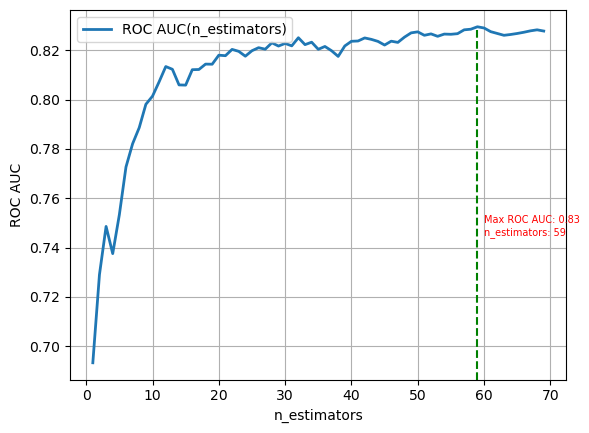

In [44]:
ax = plt.subplot()
_ = ax.plot(n_estimators_values, roc_auc_values, linewidth=2.0, label='ROC AUC(n_estimators)')
best_roc_auc = max(roc_auc_values)
best_n_estimators = n_estimators_values[np.argmax(roc_auc_values)]
ax.axvline(best_n_estimators, ymax = 0.95, linestyle = '--', color='green')
ax.text(best_n_estimators + 1,  0.75, f'Max ROC AUC: {best_roc_auc:.2f}', color='red', fontsize=7)
ax.text(best_n_estimators + 1,  0.745, f'n_estimators: {best_n_estimators}', color='red', fontsize=7)
ax.grid(True)
ax.set_ylabel('ROC AUC')
ax.set_xlabel('n_estimators')
_ = ax.legend()

<font color=blue>

Видно, что, чем больше `n_estimators`, те выше качество `ROC AUC` модели. Однако после `n_estimators` $> 50$, величина `ROC AUC` стабилизируется. Формально максимум `ROC AUC`$\approx 0.83$ был достигнут при `n_estimators`$= 59$.
    
</font>

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [45]:
from sklearn.model_selection import cross_validate

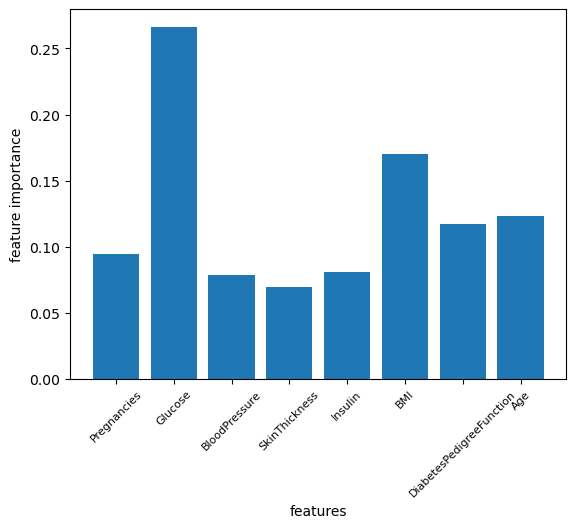

In [46]:
best_rf = RandomForestClassifier(n_estimators=50, 
                                 random_state=42, 
                                 max_depth = best_max_depth, 
                                 min_samples_split = best_min_samples_split)

output = cross_validate(best_rf, X_train_full, y_train_full, cv=skf, scoring='f1', return_estimator=True)

best_estimator = output['estimator'][np.argmax(output['test_score'])]
ax = plt.subplot()
ax.bar(X.columns.to_list(), best_estimator.feature_importances_)
_ = ax.set_xticklabels(X.columns.to_list(), rotation=45, fontsize=8)
ax.set_xlabel("features")
_ = ax.set_ylabel("feature importance")

<font color=blue>
    
Построим также 'ящики с усами' по 5ти значениям `feature_importance` каждого признака.
    
</font>

In [47]:
feature_importances = dict()
for fold in range(5):
    feature_importances[f'fi fold{fold}']=output['estimator'][fold].feature_importances_

df_fi = pd.DataFrame(feature_importances).T
df_fi.columns = X.columns
df_fi

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
fi fold0,0.077558,0.305911,0.079609,0.066227,0.077627,0.167819,0.102277,0.122972
fi fold1,0.089001,0.288134,0.086236,0.063743,0.076158,0.166038,0.111716,0.118974
fi fold2,0.101462,0.274681,0.074963,0.079029,0.087926,0.167435,0.114816,0.099688
fi fold3,0.090505,0.281727,0.073327,0.066190,0.091104,0.161465,0.111454,0.124230
fi fold4,0.094461,0.266298,0.078344,0.069391,0.080744,0.170213,0.117414,0.123135


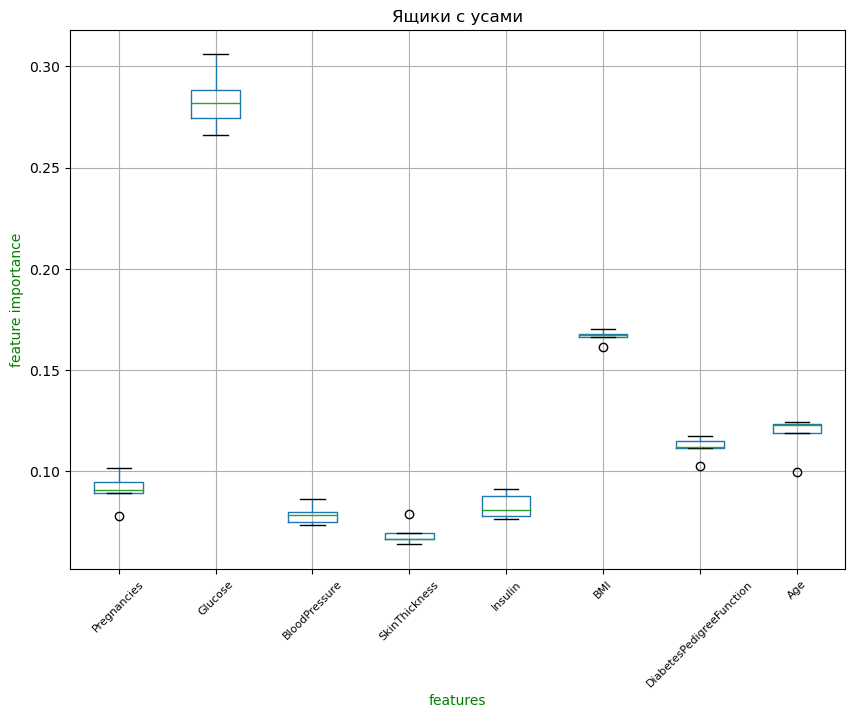

In [48]:
ax = df_fi.boxplot(figsize=(10,7))
ax.grid(True)
ax.set_xticklabels(df_fi.columns.to_list(), rotation=45, fontsize=8)
ax.xaxis.label.set_color('green')
ax.yaxis.label.set_color('green')
ax.set_title("Ящики с усами")
ax.set_xlabel("features")
_ = ax.set_ylabel("feature importance")

<font color=blue>

Как видно на обоих диаграммах самым важным признаком оказался `Glucose`.    
    
</font>